<div class="alert alert-block alert-success">
<h1>EEG Preprocessing with MNE</h1>
</div>

In [11]:
%matplotlib inline
import os
import os.path as op
import mne
import numpy as np
import pandas as pd

### 1. Importing Raw  Data

>You need to provide your own EEG data with BrainVision format which have three files named  .vhdr, .vmrk and .eeg

<div class="alert alert-block alert-info">
<b>Tip:</b> You can change read_raw_brainvision() <a href="https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html" title="Data EEG formats"> module based on your data format</a> 
</div>

In [16]:
examples_dir = 'eeg\sub-005-eeg'                                 # Path to the raw EEG Data folder
vhdr_file = op.join(examples_dir, 'sub-005.vhdr')                # Path to the raw EEG header file
raw = mne.io.read_raw_brainvision(vhdr_file, misc='auto')        # Returns a Raw object containing BrainVision data
raw.load_data()                                                  # Loading continuous data

Extracting parameters from D:\PhD\PDM_data\eeg_outside-MRT\sub-005\sourcedata-eeg_outside-MRT\eeg\sub-005_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


<ipython-input-16-81af91281579>:4: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(vhdr_file, misc='auto')        # Returns a Raw object containing BrainVision data


Reading 0 ... 6110299  =      0.000 ...  1222.060 secs...


<RawBrainVision | sub-005_task-pdm_acq-outsideMRT_eeg.eeg, 64 x 6110300 (1222.1 s), ~2.91 GB, data loaded>

In [18]:
raw.set_channel_types({'EOG':'eog'})   #If you have Electrooculography (EOG) channel,  set its name manually
raw.set_channel_types({'ECG':'ecg'})   #If you have Electrocardiograms (ECG) channels, set its name manually

<RawBrainVision | sub-005_task-pdm_acq-outsideMRT_eeg.eeg, 64 x 6110300 (1222.1 s), ~2.91 GB, data loaded>

### 2. Downsampling

In [19]:
raw.resample(256, npad="auto")    # set sampling frequency to 256 points per second

<RawBrainVision | sub-005_task-pdm_acq-outsideMRT_eeg.eeg, 64 x 312847 (1222.1 s), ~152.9 MB, data loaded>

>according to the Nyquist frequency, sampling rate should be at least two times of frequency. 
Moreover, 128 points are suitable and 256 points are desirable


### 3. Filtering the data

In [21]:
raw.filter(1, 30, fir_design='firwin', picks=['eeg'])  # band-pass filter from 1 to 30 frequency over just
                                                       # EEG channel and not EEG channel

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)



<RawBrainVision | sub-005_task-pdm_acq-outsideMRT_eeg.eeg, 64 x 312847 (1222.1 s), ~152.9 MB, data loaded>

>Lw-pass filter with 1 Hz cutoff frequency for removing low-frequency drifts.
    High-pass filter with 30 Hz cutoff frequency for deteriorating the effect of
    the AC power line frequency, cell phones, the geomagnetic field and so forth.
    Therefore, a band-pass filter was used in the range 1Hz-30Hz with one step.
    You can apply another band pass filter due to your own assumtions and hypotheses.
    I recommend that band pass filtering would be better to occurr before the EEG
    data epoching and artifact removal with ICA.

### 4. Rereference

In [22]:
raw.set_eeg_reference('average', projection=True).apply_proj()  # re-referencing with the virtual average reference

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawBrainVision | sub-005_task-pdm_acq-outsideMRT_eeg.eeg, 64 x 312847 (1222.1 s), ~152.9 MB, data loaded>

### 5. Visual Inspection

###### 5.1 Plot continuous data

In [ ]:
%matplotlib qt
raw.plot()       # plot the EEG data. Use the '%matplotlib qt' to see 
                 # the data in a bright way and move conveniently

>Use of visual inspection to reject some segments which have abnormal frequency,
     signal discontinuous, abrupt jumping, irrelevant-task and son on.
     Trace all EEG channels during time.
     The best way to remove segtion of the data is deleting annotations in the segtion.
     In addition, when you see irrelavant task or noise segemt in specefict channel,
     you shoud remove the sement in all channels
     Afterward, The instances of noisy segment which should be removed are created by 
     providing a EXCELL file with two columns of onsets and  offsets with descriptions
     for each segment. The onsets and offsets are marked as seconds. onset refers to time
     from start of the data. offset refers to time from end of the data

###### 5.2 channel bad correction

In [25]:
raw.info['bads'] = ['Fp1','Fp2','Fpz']         # Select bad channels visually to interpolate them with channels
                                               # Sleceted channels are not real
raw = raw.interpolate_bads(reset_bads=False)

Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 3 sensors


###### 5.3 Delete annotations

In [28]:
visual_inspection = pd.read_csv(examples_dir + "\\sub-005_visual_inspection.csv")  # Path to annotation folder
                                                                                  # remove each segment with start and end time
for i in range(visual_inspection.shape[0]):         
    result = np.where((mne.events_from_annotations(raw)[0][:,0] > visual_inspection['Start'][i]*256) & 
                      (mne.events_from_annotations(raw)[0][:,0] < visual_inspection['End'][i]*256));
    raw.annotations.delete(result)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulu

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulu

In [ ]:
raw.plot()    # Let's see the data again to be sure that the noisy segemnts have been deleted

### 6. Segmenting continuous data into epochs and setting Ampilitude ceriteria

In [31]:
events_from_annot, event_dict = mne.events_from_annotations(raw)# Get events and event_id from an Annotations object.
event_dict = {'74':74, '75':75, '76':76}                        # Event dictionaries to extract epochs from continuous data, 
reject_criteria = dict(eeg=100e-6)                              # Absolute Amplitude of each epoch sould be smaller than 100 μV
                                                                # tmin is start time before event, tmax is end time after event
                                                                # - 100 ms (baseline) of cue's onset to 600 ms
epochs = mne.Epochs(raw, events_from_annot, event_id=event_dict, tmin=-0.1, tmax=1.6,
                    reject=reject_criteria, baseline = (None,0), preload=True, picks=['eeg'])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Not setting metadata
Not setting metadata
265 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 265 events and 437 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'AF4', 'F6', 'AF8']
    Rejecting  epoch based on EEG : ['AF3', 'AF4', 'AF7', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['AF3', 'AF4', 'AF7', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['AF3', 'AF4', 'AF7', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['F4', 'AF4', 'F6']
    Rejecting  epoch based on EEG : ['F4', 'F8', 'F6', 'AF8']
    Rejecting  epoch based on EEG : ['AF3', '

### 7. Independent Component Analysis  (ICA)

<div class="alert alert-block alert-warning">
<b>Warning:</b> Ignore 7.1, 7.3 and 7.4 subsections, if there are no EOG and ECG channels
</div>

###### 7.1 Epoching EOG and ECG

EOG channel index for this subject is: [30]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 190 significant peaks
Number of EOG events detected : 190
Not setting metadata
Not setting metadata
190 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 190 events and 257 original time points ...
0 bad epochs dropped
Applying 

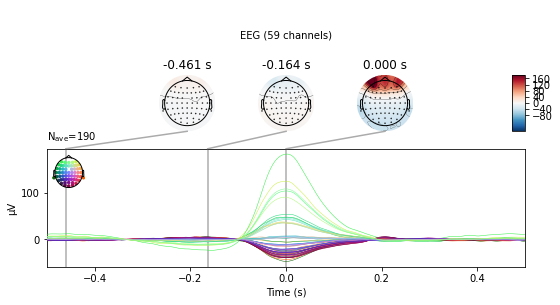

In [32]:
                                                                  # Ocular artifacts (EOG)
eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()   # Conveniently generate epochs around EOG artifact events
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2560 samples (10.000 sec)

Number of ECG events detected : 1670 (average pulse 81 / min.)
Not setting metadata
Not setting metadata
1670 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1670 events and 257 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Projections have already been applied. Setting proj attribute to True.


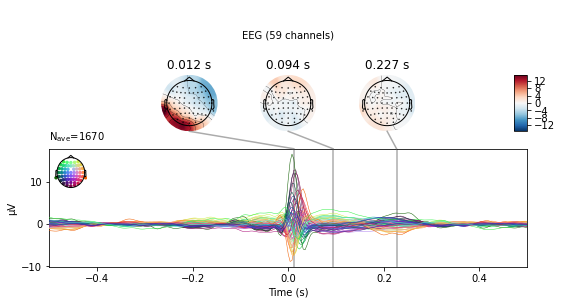

In [33]:
                                                                  # Heartbeat artifacts (ECG)
ecg_evoked = mne.preprocessing.create_ecg_epochs(raw).average()   # Conveniently generate epochs around ECG artifact events
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

###### 7.2 ICA run

In [35]:
ica = mne.preprocessing.ICA(n_components=50, random_state=97, method='fastica')
ica.fit(epochs)                                      # Data decomposition with 50 components and fastica method.

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 50 components
Fitting ICA took 19.8s.


<ICA | epochs decomposition, fit (fastica): 104006 samples, 50 components, channels used: "eeg">

>Number of component should be not more than number of channels.
    Sometimes, large number of components lead to indiscriminate decomposition
    which we cannot distinguish signal or artifacr components.
    Therefore, you need to choose specific the number of your own Data manually to 
    differentiate conveniently task-relavant components from task-irrelavant components.

In [ ]:
%matplotlib inline
# %matplotlib qt
ica.plot_components()  # Plot all decomposed components
                       # Set bad components visually

###### 7.3 EOG component rejection automatically

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 s

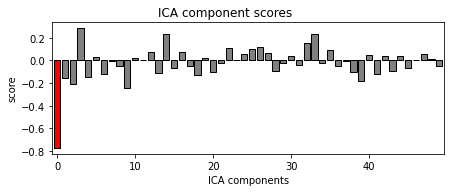

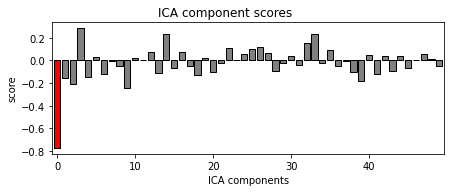

In [45]:
ica.exclude = []                                    # to save list of EOG comonents
eog_indices, eog_scores = ica.find_bads_eog(raw)    # Detect EOG related components using correlation
                                                    # Return the indices of EOG related components, sorted by score
ica.exclude = eog_indices
ica.plot_scores(eog_scores)                          # Barplot of ICA component "EOG match" scores
if len(eog_indices)>0:
    ica.plot_properties(epochs, picks=eog_indices)   # plot diagnostics
    ica.plot_sources(epochs)                         # plot ICs applied to raw data, with EOG matches highlighted
    ica.plot_sources(eog_evoked)                     # plot ICs applied to the averaged EOG epochs,
                                                     # with EOG matches highlighted

In [42]:
ica.exclude

[0]

###### 7.4 EOG component rejection automatically

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2560 samples (10.000 sec)



<ipython-input-46-5a87a7d41ef7>:2: DeprecationWarning: The default for "threshold" will change from None to"auto" in version 0.22. To avoid this warning, explicitly set threshold to "auto".
  ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='ctps') # Detect EOCG related components using correlation


Number of ECG events detected : 1670 (average pulse 81 / min.)
Not setting metadata
Not setting metadata
1670 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1670 events and 257 original time points ...
0 bad epochs dropped


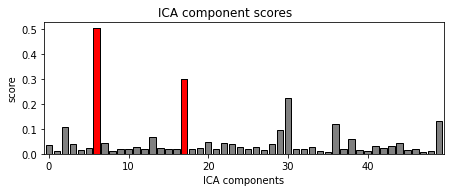

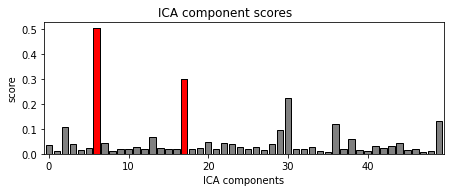

In [46]:
ica.exclude = []                                                # to save list of EOG comonents#
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='ctps') # Detect EOCG related components using correlation
                                                                # Return the indices of ECG related components, sorted by score
ica.exclude = ecg_indices
ica.plot_scores(ecg_scores)                                     # barplot of ICA component "ECG match" scores
if len(ecg_indices)>0:
    ica.plot_properties(epochs, picks=ecg_indices)              # plot diagnostics
    ica.plot_sources(epochs)                                    # plot ICs applied to raw data, with ECG matches highlighted
    ica.plot_sources(ecg_evoked)                                # plot ICs applied to the averaged ECG epochs, 
                                                                # with ECG matches highlighted

In [44]:
ica.exclude

[6, 17]

###### 7.5 Reconstruction of EEG data

In [ ]:
ica.exclude = [11, 26, 29, 30, 33, 34, 35, 36, 38, 44, 48, 49, 0, 6, 17] 
                                        # Put all comonent which you want to remove containg inspected (manual) 
                                        # [11, 26, 29, 30, 33, 34, 35, 36, 38, 44, 48, 49], EOG [0] and ECG [6,17] components
                                        # Selected components are not real
ica.apply(epochs)                       # Channels can be reconstructed using the ICA object’s apply()

<div class="alert alert-block alert-info">
<b>Tip:</b> Exprimentally, I try not to remove more than 30% of the total independent components
</div>

### 8. Save preprocessed EEG data  

In [ ]:
epochs.save(examples_dir + "\\sub-006_prerprocessed.fif")